In [ ]:
#access gdrive folder: 20_440Project_JS_TF_AMB must be in MyDrive
from google.colab import drive

drive.mount("/content/drive")
%cd /content/drive/My Drive/20_440Project_JS_TF_AMB

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/11ayn8NvvhQcP_j3xRQ6p0HIXj3agZbuK/20_440Project_JS_TF_AMB


# Install and load dependencies

In [ ]:
%pip install pydeseq2
%pip install scanpy
%pip install sanbomics
%pip install bioinfokit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 408.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 10.9 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=7672c53496ad8f73ef55ccc5ab04c5afd357419ca0084da8b31e710423d99f88
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 kB 2.7 MB/s eta 0:00:00
  Preparing met

In [ ]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from functools import reduce
from sanbomics.plots import volcano
from bioinfokit import analys,visuz


import pandas as pd
import seaborn as sns
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

# Run DeSeq2

In [ ]:
merged = pd.read_csv('dataset/MetaData/MetaData_unDiffs_TF5.tsv', delimiter='\t')
merged.set_index(merged.columns[0], inplace=True)
merged.sort_index(inplace=True)
merged *= 100
merged = merged.astype(int)

In [ ]:
labels = ['Primary'] * 5 + ['hiPSC'] * 6

metadata = pd.DataFrame(zip(merged.index, labels),
                        columns = ['Sample', 'Condition'])
metadata = metadata.set_index('Sample')

In [ ]:
dds = DeseqDataSet(counts=merged.iloc[0:11],
            metadata=metadata,
            design_factors="Condition")

In [ ]:
dds.deseq2()

Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 27.71 seconds.

Fitting dispersion trend curve...
... done in 0.91 seconds.

Fitting MAP dispersions...
... done in 28.45 seconds.

Fitting LFCs...
... done in 20.32 seconds.

Replacing 0 outlier genes.



In [ ]:
stat_res = DeseqStats(dds, contrast = ('Condition','Primary','hiPSC'))

stat_res.summary()
res = stat_res.results_df


Running Wald tests...


Log2 fold change & Wald test p-value: Condition Primary vs hiPSC
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       597.951407        1.764927  1.070939  1.648019  0.099349  0.175739
NAT2        49.594378       -3.428577  1.282855 -2.672614  0.007526  0.019507
ADA        512.299541       -1.919445  1.330072 -1.443114  0.148988  0.242165
CDH2      7646.458534        2.310623  0.581110  3.976226  0.000070  0.000292
AKT3       824.609763       -1.896351  1.164084 -1.629050  0.103302  0.181190
...               ...             ...       ...       ...       ...       ...
PTBP3     6501.382642       -1.761765  0.387926 -4.541492  0.000006  0.000029
KCNE2       21.737960       -1.708339  1.409499 -1.212019  0.225505  0.333934
DGCR2     1554.636168       -1.129729  0.438213 -2.578033  0.009936  0.024868
CASP8AP2  1352.900659        0.281156  0.329985  0.852025  0.394200  0.509834
SCO2       418.453718        2.972281  2.393267  1.241934  0.214261  0.321771

... done in 4.29 seconds.



# Heat Map

In [ ]:
import sys
sys.setrecursionlimit(10000)  # Set a higher recursion limit (adjust the value as needed)

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


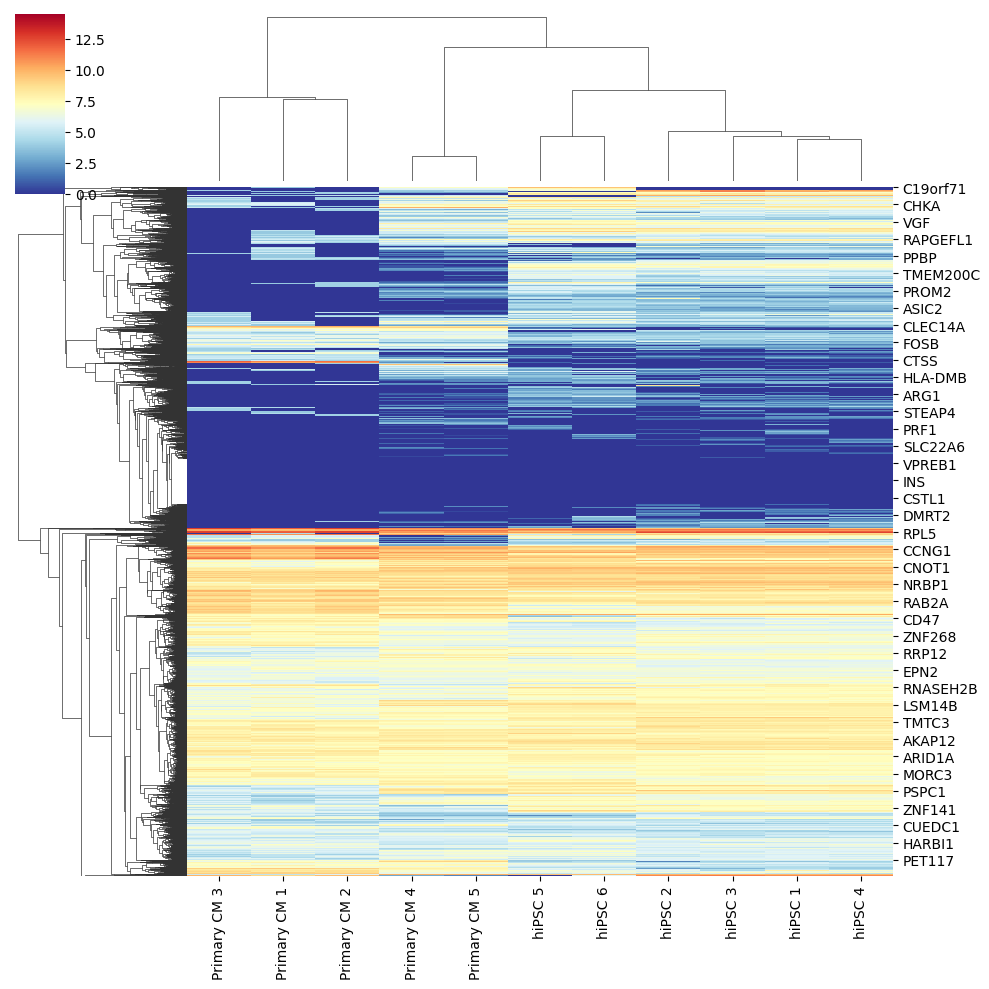

In [ ]:
dds.layers['log1p'] = np.log1p(dds.layers['normed_counts'])
dds_res = dds[:, res.index]

pattern_repetitions = {'Primary CM': 5, 'hiPSC': 6}
col_labels = [f'{pattern} {i}' for pattern, repetitions in pattern_repetitions.items() for i in range(1, repetitions + 1)]

grapher_res = pd.DataFrame(dds_res.layers['log1p'].T,
                       index=dds_res.var_names, columns=col_labels)

sns.clustermap(grapher_res, cmap='RdYlBu_r')

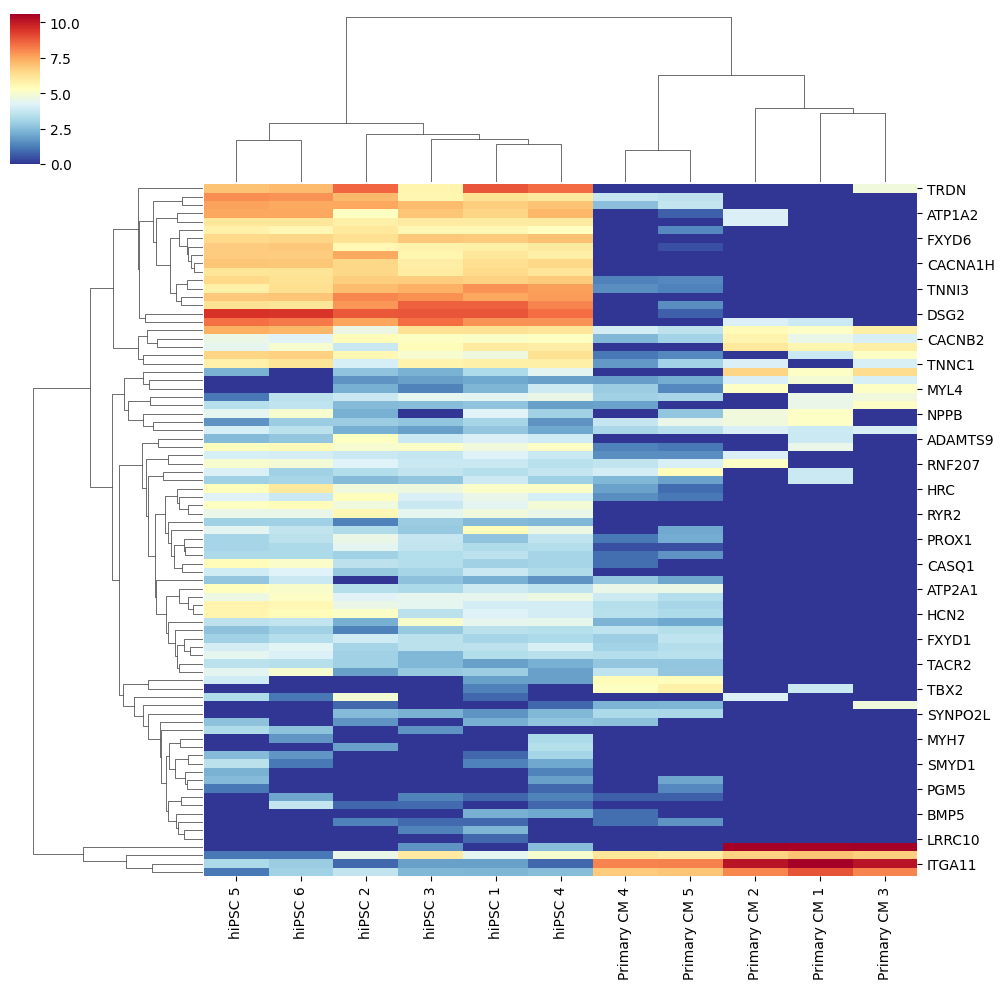

In [ ]:
cardiac_genes = pd.read_csv('cardiac_genes.csv', delimiter='\t')
subset_grapher_res = grapher_res.loc[cardiac_genes['Gene']]

sns.clustermap(subset_grapher_res, cmap='RdYlBu_r',cbar_pos=(0, 0.83, .03, .15))